In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cvxpy as cp
import nlopt
from sklearn import linear_model
from matplotlib.ticker import PercentFormatter

C:\Users\Tianying Zhou\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [2]:
Assets = pd.read_csv("C:/Users/Tianying Zhou/Desktop/Assets.csv").set_index("Date")
Factors = pd.read_csv("C:/Users/Tianying Zhou/Desktop/Factors.csv").set_index("Date")

In [3]:
AssetCov = np.asmatrix(Assets.cov())
AssetRtn = np.asarray(Assets.mean(axis = 0))

## LASSO

In [4]:
AssetExpo = np.empty(shape = (0, 6))
Res = pd.DataFrame()

for i in Assets.columns:
    y = Assets[i].to_frame()
    lasso_reg = linear_model.Lasso(alpha = 1e-05, fit_intercept = True)
    lasso_reg.fit(Factors, y)
    lasso_reg.coef_[abs(lasso_reg.coef_) < 0.05] = 0
    AssetExpo = np.vstack((AssetExpo, lasso_reg.coef_))
    residual = (y[i] - lasso_reg.predict(Factors)).to_frame(name = y.columns[0])
    if len(Res) == 0:
        Res = residual
    else:
        Res = Res.merge(residual, left_index = True, right_index = True)

AssetExpo = pd.DataFrame(AssetExpo, columns = Factors.columns, index = Assets.columns)

## Factor based Asset Allocation

### Exposure

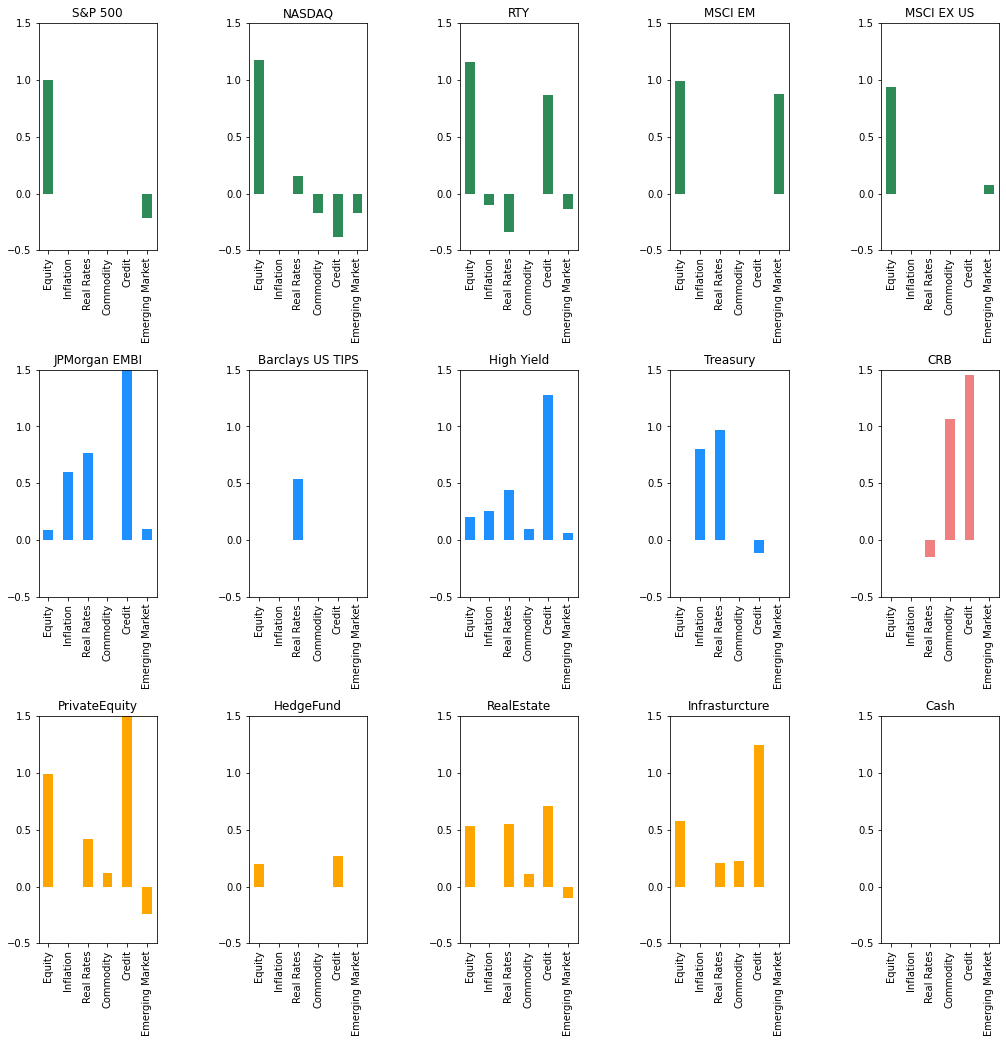

In [5]:
figure, axe = plt.subplots(3, 5)
figure.tight_layout()

for i in range(15):
    x = math.floor(i/5)  # row = x, column = y
    y = i - 5*x
    if i in [0, 1, 2, 3, 4]:
        c = 'seagreen'
    if i in [5, 6, 7, 8]:
        c = 'dodgerblue'
    if i == 9:
        c = "lightcoral"
    if i in [10, 11, 12, 13]:
        c = "orange"
    if i == 14:
        c = "yellow"
    AssetExpo.iloc[i, :].plot.bar(ax = axe[x, y], color = c, title = AssetExpo.index[i], figsize = (15, 15), ylim = (-.5, 1.5), yticks = [-0.5, 0 , 0.5, 1, 1.5])
    plt.rc('font', family = 'Times New Roman')
    # plt.savefig('exposure.png', dpi = 300)

### Case 1  Constrains – asset weights range between (-100%, 100%); fully invest

In [6]:
lam = 0.99

TargetExpo = np.array([0.45, 0.29, 0.31, 0.07, 0.12, 0.12])

FacCov = np.asmatrix(Factors.cov())
SpeCov = np.asmatrix(Res.cov())

n = len(AssetRtn)
w = cp.Variable(n)

M = w @ np.asarray(AssetExpo) - TargetExpo
risk = (1 - lam)*cp.quad_form(M, np.identity(len(TargetExpo))) + lam*cp.quad_form(M, FacCov) + lam*cp.quad_form(w, SpeCov)

problem = cp.Problem(cp.Minimize(risk), [sum(w) == 1, w >= -1, w <= 1])
problem.solve()

3.151394325426106e-06

In [7]:
w_1 = pd.DataFrame({"w": w.value, "asset" : AssetExpo.index}).sort_values(by = "w", ascending = False)
expo_1 = pd.DataFrame({"exposure": w.value @ np.asarray(AssetExpo), "factor" : AssetExpo.columns})

Text(0.0, 1.0, 'Asset weights')

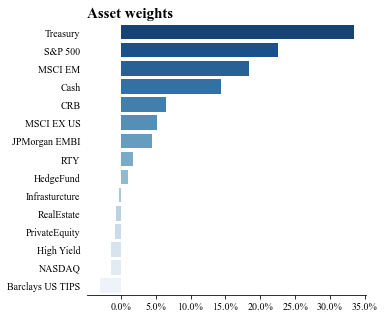

In [8]:
plt.figure(figsize = (5, 5)) # , dpi = 200
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "w", y = "asset", data = w_1, palette = "Blues_r").set(xlabel = None, ylabel = None) # PiYG
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title("Asset weights", loc = "left", fontsize = 15, fontweight= "bold")
# plt.savefig('11.png', dpi = 300)

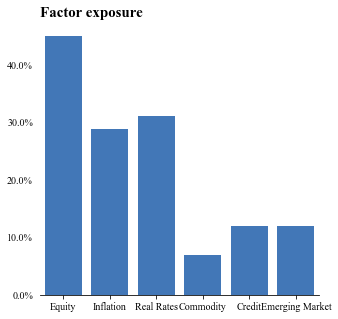

In [9]:
plt.figure(figsize = (5, 5)) # , dpi = 200
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "factor", y = "exposure", data = expo_1, color = "#2e75cb").set(xlabel = None, ylabel = None) # PiYG
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Factor exposure", loc = "left", fontsize = 15,fontweight= "bold")
plt.show()
# plt.savefig('12.png', dpi = 300)

### Case 2: Constrains – Long only with minimum asset weight of 2.5%; fully invest

In [10]:
lam = 0.99

TargetExpo = np.array([0.45, 0.29, 0.31, 0.07, 0.12, 0.12])

FacCov = np.asmatrix(Factors.cov())
SpeCov = np.asmatrix(Res.cov())

n = len(AssetRtn)
w = cp.Variable(n)

M = w @ np.asarray(AssetExpo) - TargetExpo
risk = (1 - lam)*cp.quad_form(M, np.identity(len(TargetExpo))) + lam*cp.quad_form(M, FacCov) + lam*cp.quad_form(w, SpeCov)

problem = cp.Problem(cp.Minimize(risk), [sum(w) == 1, w >= 0, w <= 1])
problem.solve()

w_2 = pd.DataFrame({"w": w.value, "asset" : AssetExpo.index}).sort_values(by = "w", ascending = False)
expo_2 = pd.DataFrame({"exposure": w.value @ np.asarray(AssetExpo), "factor" : AssetExpo.columns})

Text(0.0, 1.0, 'Asset weights')

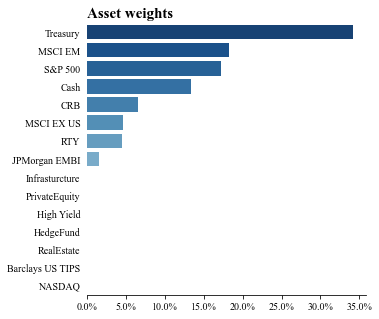

In [11]:
plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "w", y = "asset", data = w_2, palette = "Blues_r").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title("Asset weights", loc = "left", fontsize = 15, fontweight= "bold")
# plt.savefig('11.png', dpi = 300)

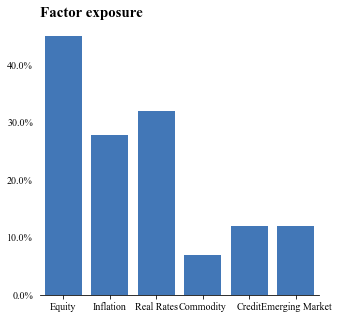

In [12]:
plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "factor", y = "exposure", data = expo_2, color = "#2e75cb").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Factor exposure", loc = "left", fontsize = 15,fontweight= "bold")
plt.show()
# plt.savefig('12.png', dpi = 300)

### Case 3 Exclude illiquid assets

In [13]:
lam = 0.99

TargetExpo = np.array([0.45, 0.29, 0.31, 0.07, 0.12, 0.12])

FacCov = np.asmatrix(Factors.cov())
SpeCov = np.asmatrix(Res.cov())

n = len(AssetRtn)
w = cp.Variable(n)

M = w @ np.asarray(AssetExpo) - TargetExpo
risk = (1 - lam)*cp.quad_form(M, np.identity(len(TargetExpo))) + lam*cp.quad_form(M, FacCov) + lam*cp.quad_form(w, SpeCov)

problem = cp.Problem(cp.Minimize(risk), 
                     [sum(w) == 1, 
                      w >= 0, 
                      w <= [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]])
problem.solve()

2.343505502890601e-05

Text(0.0, 1.0, 'Asset weights')

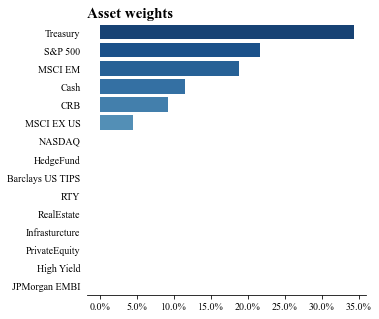

In [14]:
w_3 = pd.DataFrame({"w": w.value, "asset" : AssetExpo.index}).sort_values(by = "w", ascending = False)
expo_3 = pd.DataFrame({"exposure": w.value @ np.asarray(AssetExpo), "factor" : AssetExpo.columns})

plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "w", y = "asset", data = w_3, palette = "Blues_r").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title("Asset weights", loc = "left", fontsize = 15, fontweight= "bold")

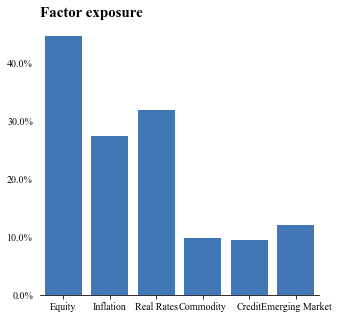

In [15]:
plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "factor", y = "exposure", data = expo_3, color = "#2e75cb").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Factor exposure", loc = "left", fontsize = 15,fontweight= "bold")
plt.show()

### Case 4 Factor risk parity

In [16]:
lam = 0.99

TargetExpo = np.repeat(1/6, 6)

FacCov = np.asmatrix(Factors.cov())
SpeCov = np.asmatrix(Res.cov())

n = len(AssetRtn)
w = cp.Variable(n)

M = w @ np.asarray(AssetExpo) - TargetExpo
risk = (1 - lam)*cp.quad_form(M, np.identity(len(TargetExpo))) + lam*cp.quad_form(M, FacCov) + lam*cp.quad_form(w, SpeCov)

problem = cp.Problem(cp.Minimize(risk), [sum(w) == 1, w >= -0.5, w <= 0.3])
problem.solve()

8.272289724395408e-06

In [17]:
w_4 = pd.DataFrame({"w": w.value, "asset" : AssetExpo.index}).sort_values(by = "w", ascending = False)
expo_4 = pd.DataFrame({"exposure": w.value @ np.asarray(AssetExpo), "factor" : AssetExpo.columns})

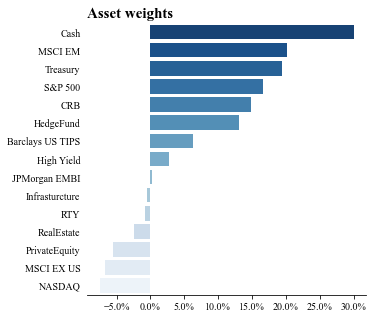

In [18]:
plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "w", y = "asset", data = w_4, palette = "Blues_r").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title("Asset weights", loc = "left", fontsize = 15, fontweight = "bold")
plt.show()

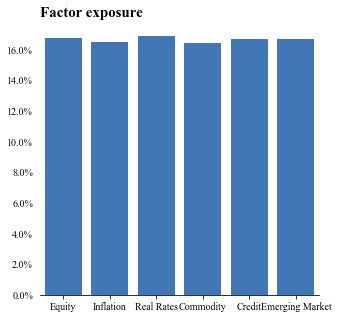

In [19]:
plt.figure(figsize = (5, 5))
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "factor", y = "exposure", data = expo_4, color = "#2e75cb").set(xlabel = None, ylabel = None) # PiYG
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Factor exposure", loc = "left", fontsize = 15, fontweight = "bold")
plt.show()

### Assets Risk Parity

In [20]:
Assets1 = Assets.drop(labels = "Cash", axis = 1)

AssetCov1 = Assets1.cov()
AssetRtn1 = Assets1.mean(axis = 0)

opt = nlopt.opt(nlopt.LD_SLSQP, len(AssetRtn1))

def f(x, grad):
    if grad.size > 0:
        for i in range(len(x)):
            grad[i] = [1/i for i in x][i]
    return sum([np.log(abs(i)) for i in x])

def g(x, grad):
    x = pd.Series(x)
    x.index = AssetRtn1.index
    a = x.dot(AssetCov1 + AssetCov1.T)
    if grad.size > 0:
        for i in range(len(x)):
            grad[i] = a[i]
    return x.dot(AssetCov1).dot(x) - 0.02

opt.set_max_objective(f)
opt.add_inequality_constraint(g, 1e-8)

opt.set_lower_bounds([-10 for i in range(len(AssetRtn1))])
opt.set_upper_bounds([10 for i in range(len(AssetRtn1))])

opt.set_xtol_rel(1e-8)
opt.set_maxeval(1000000)

xopt = opt.optimize([1/len(AssetRtn1) for i in range(len(AssetRtn1))])

In [21]:
w_5 = np.asarray(list(xopt) + [1 - sum(xopt)])
expo_5 = pd.DataFrame({"exposure": w_5 @ np.asarray(AssetExpo)})

In [22]:
sum_expo = pd.concat([expo_5, expo_1["exposure"], expo_4], axis = 1)
sum_expo.columns = ["Asset risk parity", "Target factor exposure", "Factor risk parity", "Factors"]
sum_expo = pd.melt(sum_expo, id_vars = ["Factors"])

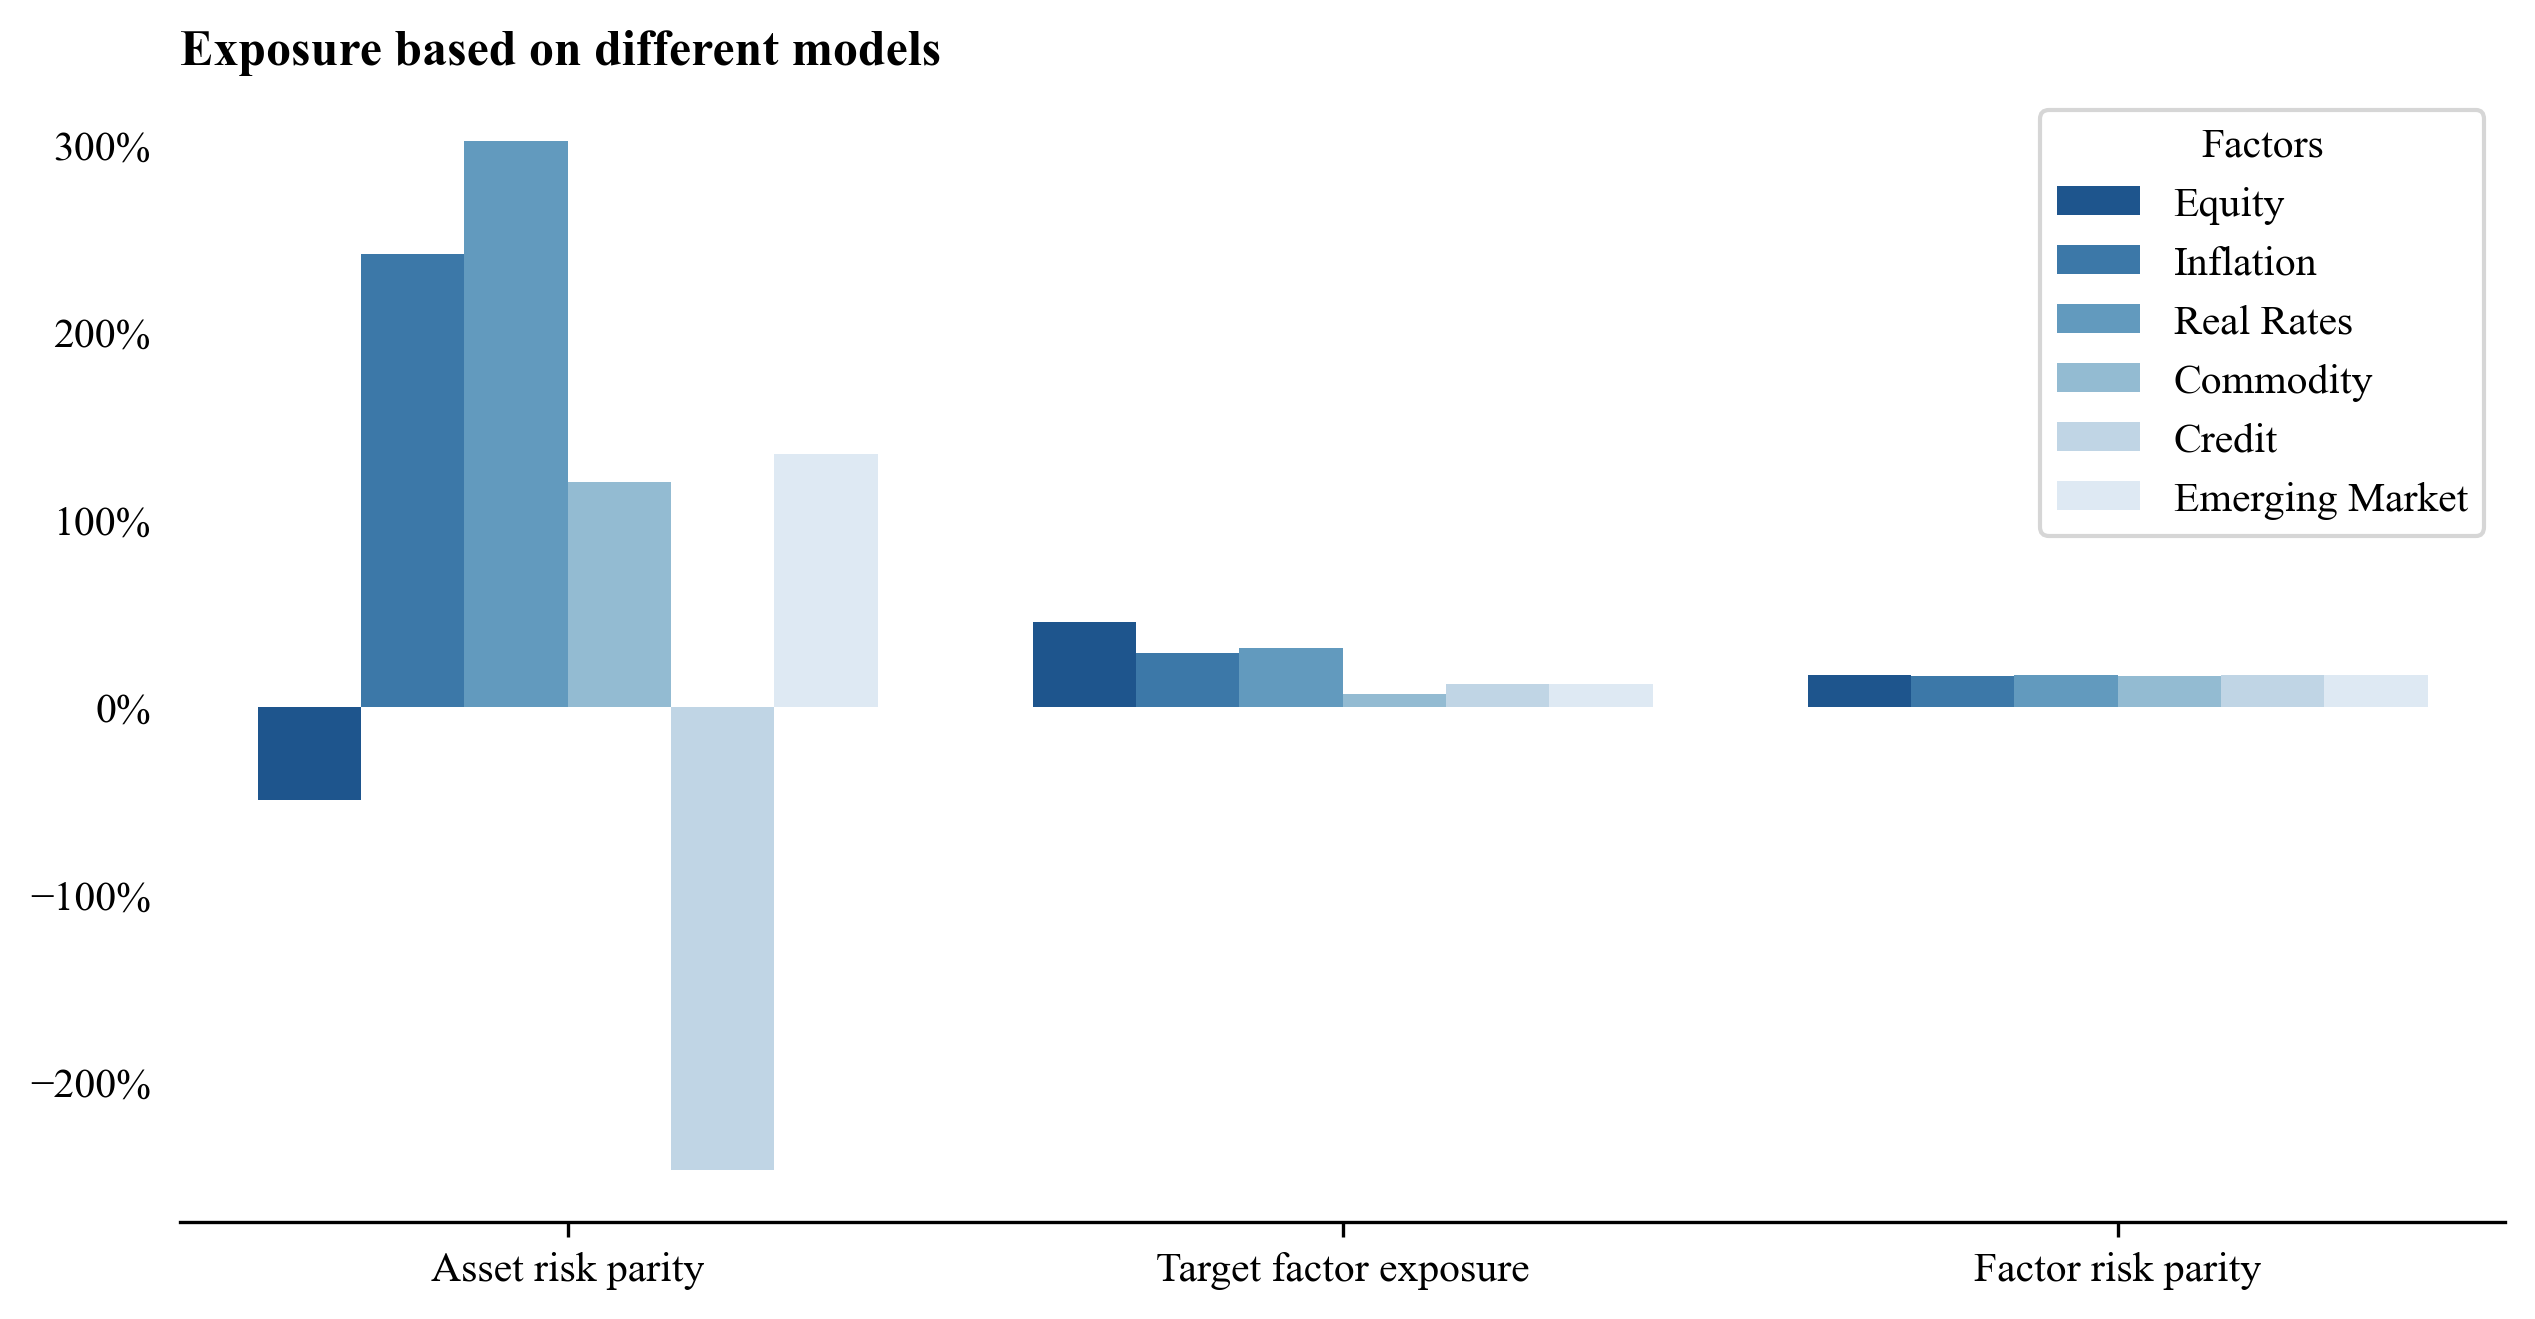

In [23]:
plt.figure(figsize = (10, 5), dpi = 300)
plt.rc('font', family = 'Times New Roman')
sns.barplot(x = "variable", y = "value", hue = "Factors", data = sum_expo, palette = "Blues_r").set(xlabel = None, ylabel = None)
sns.despine(left = True)
plt.tick_params(left = False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Exposure based on different models", loc = "left", fontsize = 12, fontweight = "bold")
plt.show()